In [740]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from collections import defaultdict
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [741]:
def create_year_dataframe(year):
    df = pd.read_csv("survey_results_public_" + str(year) + ".csv", low_memory=False)
    return df

In [742]:
years_data = [2015, 2016, 2017, 2018, 2019]

In [743]:
def create_all_dataframes(all_years):
    dict_df = {}
    for year in years_data:
        dict_df[year] = create_year_dataframe(year)
    return dict_df

In [744]:
all_years = create_all_dataframes(years_data)

In [745]:
#cleaning 2015 headers
columns_2015 = all_years[2015].iloc[0]
all_years[2015] = all_years[2015][1:]
all_years[2015].columns = columns_2015

In [746]:
def segment_by_column_and_value(df, column, value):
    return df[df[column]==value]

In [747]:
all_years[2016].rename(columns={"country":"Country"}, inplace=True)

In [748]:
def create_column_df(df_dict, column, value):
    dictionary = {}
    for key in df_dict:
        dictionary[key] = segment_by_column_and_value(df_dict[key], column, value)
    return dictionary

In [749]:
united_states = create_column_df(all_years, "Country", "United States")

<H2> Question 1: How has the survey changed over the years? </h2>

In [750]:
def get_yearly_shape(dictionary, year):
    return dictionary[year].shape[0], dictionary[year].shape[1]

In [751]:
def get_all_shapes(dictionary, years):
    rows = []
    columns = []
    for year in years:
        rows.append(get_yearly_shape(dictionary, year)[0])
        columns.append(get_yearly_shape(dictionary, year)[1])
    df = pd.DataFrame(list(zip(rows, columns, years)), columns=["NumberOfRespondents", "NumberOfQuestions", "Year"])
    return df
        

In [752]:
yearly_shapes = get_all_shapes(united_states, [2015, 2016, 2017, 2018, 2019])

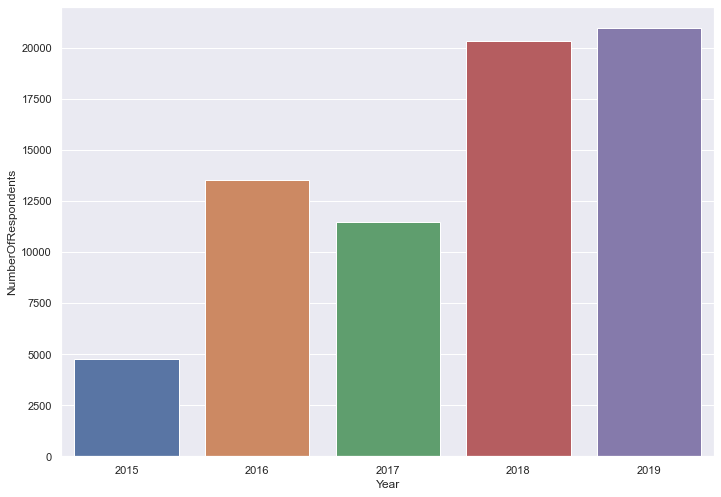

In [753]:
sns.barplot(x="Year", y="NumberOfRespondents", data=yearly_shapes)

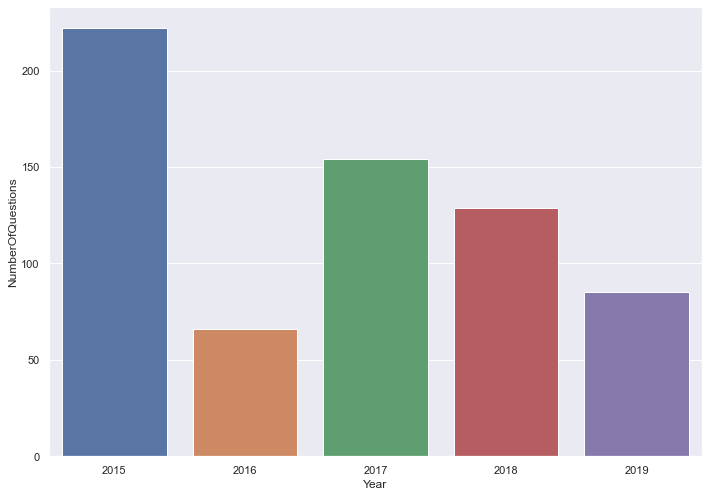

In [754]:
sns.barplot(x="Year", y="NumberOfQuestions", data=yearly_shapes)

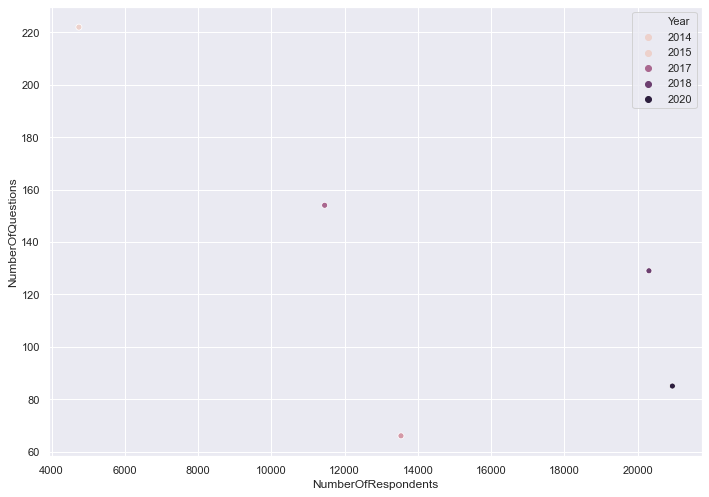

In [755]:
sns.scatterplot(x="NumberOfRespondents", y="NumberOfQuestions", hue="Year", data=yearly_shapes)

<H2> Question 2: How have the most common occupations changed in the United States over the last 3 years </h2>

In [756]:
def segment_by_column_and_value(df, column, value):
    return df[df[column]==value]

In [757]:
def create_value_df(df, year, column, column_name):
    new_df = pd.DataFrame(df[year][column].value_counts()).reset_index()
    new_df.columns=[column_name, "Count"]
    new_df["Percentage"] = new_df["Count"]/sum(new_df["Count"])
    new_df = new_df.replace("(?i).*mobile.*", "Mobile", regex=True)
    new_df = new_df.groupby("DeveloperType", as_index=False).sum()
    new_df["Year"] = year
    new_df.sort_values("Percentage", ascending=False, inplace=True)
    return new_df

In [758]:
def split_words(df, year, column, column_name):
    all_the_words = defaultdict(int) 
    for row in df[year][column]:
        if isinstance(row, float):
            all_the_words[row] += 1
        else:
            for word in row.split(";"):
                all_the_words[word.strip()] += 1
    new_df = pd.DataFrame(pd.Series(all_the_words)).reset_index()
    new_df.columns = [column_name, "Count"]
    new_df["Percentage"] = new_df["Count"] / sum(new_df["Count"])
    new_df["Year"] = year
    new_df.sort_values('Percentage', ascending=False, inplace=True)
    return new_df

In [759]:
occupation_2015 = create_value_df(united_states, 2015, "Occupation", "DeveloperType")
occupation_2016 = create_value_df(united_states, 2016, "occupation", "DeveloperType")
#occupation_2017 = split_words(all_years, 2017, "DeveloperType", "DeveloperType")
occupation_2018 = split_words(united_states, 2018, "DevType", "DeveloperType")
occupation_2019 = split_words(united_states, 2019, "DevType", "DeveloperType")

In [760]:
occupation_df = occupation_2015.append(occupation_2016).append(occupation_2018).append(occupation_2019)

In [761]:
def standardize_developer_types(df, regexes, words):
    new_df = df.replace(regexes, words, regex=True)
    return new_df

In [762]:
regexes = ["(?i).*full-stack.*", "(?i).*back-end.*", "(?i).*front-end.*", "(?i).*embedded.*", "(?i).*desktop.*", "(?i).*executive.*", "(?i).*devops.*", "(?i).*mobile.*" ] 
words = ["Full-stack", "Back-end", "Front-end", "Embedded", "Desktop", "Executive", "DevOps", "Mobile"]
developer_types = ["Full-stack", "Front-end", "Back-end", "Mobile", "Student", "Desktop"]

In [763]:
standardized_data_df = standardize_developer_types(occupation_df, regexes, words)

In [764]:
graph_data = standardized_data_df[standardized_data_df["DeveloperType"].isin(developer_types)]

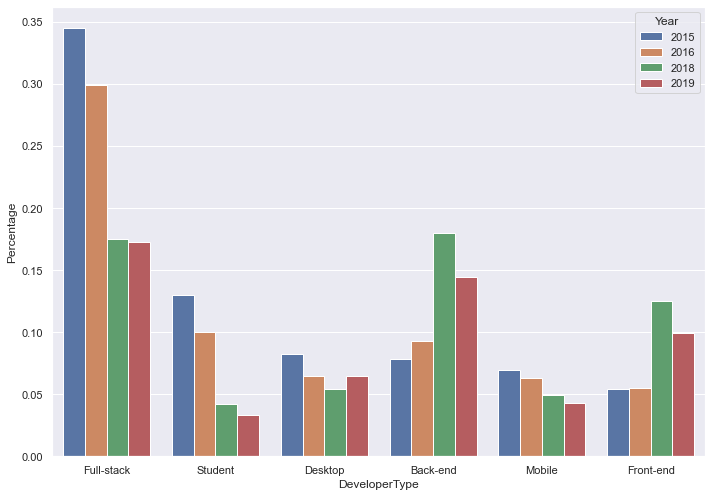

In [765]:
sns.barplot(x="DeveloperType", y="Percentage", hue="Year", data=graph_data)

<h2> Question 3: What attributes affected American salaries most in 2019? </h2>

In [766]:
united_states[2019].shape[0], united_states[2019].shape[1]

(20949, 85)

In [767]:
# There are 20,000 rows and 85 columns in 2019. Let's see what columns have missing data

<h3> Data Understanding </h3>

In [768]:
united_states[2019]["CompTotal"].isna().mean()

0.28340254904768725

In [769]:
#28 percent of the data is empty. Since CompTotal is our dependent variable, I'm going to drop all rows
# without CompTotal from our analysis

In [770]:
test_data = united_states[2019].dropna(subset=["CompTotal"])

In [771]:
missing_cols = set(test_data.columns[test_data.isna().mean()>.2])

In [772]:
missing_cols

{'BlockchainIs',
 'BlockchainOrg',
 'CodeRevHrs',
 'DatabaseDesireNextYear',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'SOHowMuchTime',
 'SONewContent',
 'WebFrameDesireNextYear',
 'WebFrameWorkedWith'}

In [773]:
#10 features are missing more than 20 percent of the data. Let's review them

In [774]:
test_data["BlockchainOrg"]

3                                        Not at all
12                                       Not at all
21                                       Not at all
22                                              NaN
25                                       Not at all
                            ...                    
88312                                    Not at all
88321                                           NaN
88323                                           NaN
88324    Implementing cryptocurrency-based products
88325                                    Not at all
Name: BlockchainOrg, Length: 15012, dtype: object

In [775]:
#I'm going to convert this column to a categorical variable with NaNs as their own column

In [776]:
#Let's checkout BlockchainIs next

In [777]:
test_data["BlockchainIs"]

3        Useful for decentralized currency (i.e., Bitcoin)
12       Useful for decentralized currency (i.e., Bitcoin)
21                                                     NaN
22       Useful for immutable record keeping outside of...
25                                           A passing fad
                               ...                        
88312                    An irresponsible use of resources
88321                                                  NaN
88323                                        A passing fad
88324                    An irresponsible use of resources
88325    Useful for decentralized currency (i.e., Bitcoin)
Name: BlockchainIs, Length: 15012, dtype: object

In [778]:
# Will handles the same as BlockChainOrg

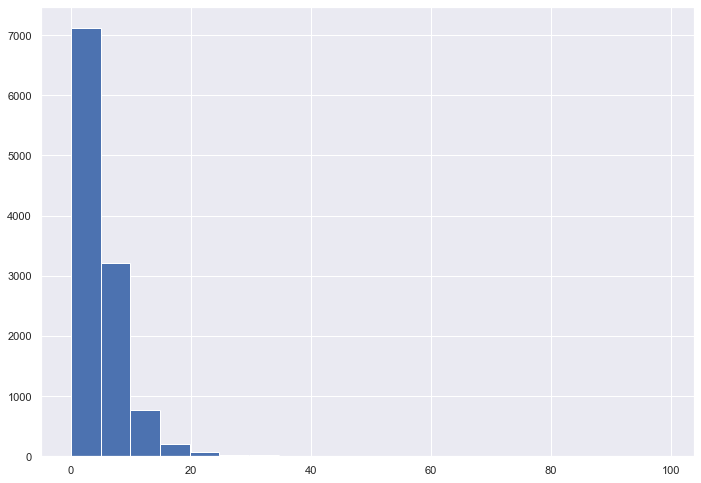

In [779]:
test_data["CodeRevHrs"].hist(bins=20)

In [780]:
# The graph is right skewed, so I will fill NaNs with the median value

In [781]:
test_data['DatabaseDesireNextYear']

3                                            MySQL;SQLite
12                                   Firebase;MySQL;Redis
21                       Elasticsearch;MySQL;Oracle;Redis
22       Couchbase;DynamoDB;Elasticsearch;Firebase;Oracle
25                Microsoft SQL Server;MySQL;Redis;SQLite
                               ...                       
88312                         Firebase;MongoDB;PostgreSQL
88321                                                 NaN
88323                                            DynamoDB
88324                                              Oracle
88325                                          PostgreSQL
Name: DatabaseDesireNextYear, Length: 15012, dtype: object

In [782]:
# I'm going to convert this to a number of desired database to learn and dummy columns. 
# We will do the same with DevType
# Nan will be a dummy variable and 0 

In [783]:
test_data["MiscTechDesireNextYear"]

3                                                     .NET
12                                      Node.js;TensorFlow
21                                                 Node.js
22                                 React Native;TensorFlow
25                                  .NET;.NET Core;Node.js
                               ...                        
88312                                              Node.js
88321                                                  NaN
88323    Apache Spark;CryEngine;Hadoop;.NET;.NET Core;T...
88324                                         Apache Spark
88325                                              Node.js
Name: MiscTechDesireNextYear, Length: 15012, dtype: object

In [784]:
# Same as before

In [785]:
test_data['MiscTechWorkedWith']

3                                          .NET
12                              Node.js;Xamarin
21                                      Node.js
22                                          NaN
25               .NET;.NET Core;Node.js;Xamarin
                          ...                  
88312                                   Node.js
88321            Apache Spark;Pandas;TensorFlow
88323    Apache Spark;Hadoop;.NET Core;Unity 3D
88324                              Apache Spark
88325                                   Node.js
Name: MiscTechWorkedWith, Length: 15012, dtype: object

In [786]:
# Same as before

In [787]:
test_data["SOHowMuchTime"]

3        31-60 minutes
12       11-30 minutes
21        0-10 minutes
22                 NaN
25       11-30 minutes
             ...      
88312    11-30 minutes
88321      60+ minutes
88323      60+ minutes
88324    11-30 minutes
88325     0-10 minutes
Name: SOHowMuchTime, Length: 15012, dtype: object

In [788]:
# will try categorical dummy variables

In [789]:
test_data["SONewContent"].value_counts()

Tech articles written by other developers;Industry news about technologies you're interested in;Tech meetups or events in your area;Courses on technologies you're interested in    2077
Tech articles written by other developers                                                                                                                                           1054
Tech meetups or events in your area                                                                                                                                                  902
Tech articles written by other developers;Industry news about technologies you're interested in                                                                                      814
Tech articles written by other developers;Courses on technologies you're interested in                                                                                               802
Courses on technologies you're interested in                               

In [790]:
# same as databases

In [791]:
test_data["WebFrameDesireNextYear"]

3                                               NaN
12                                   Express;Vue.js
21                 Angular/Angular.js;Ruby on Rails
22            Express;React.js;Ruby on Rails;Vue.js
25                       Angular/Angular.js;ASP.NET
                            ...                    
88312    Angular/Angular.js;Express;React.js;Vue.js
88321                                           NaN
88323                                           NaN
88324                                     Other(s):
88325                            React.js;Other(s):
Name: WebFrameDesireNextYear, Length: 15012, dtype: object

In [792]:
# same as databases

In [793]:
test_data["WebFrameWorkedWith"]

3                                                      NaN
12        Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js
21                        Angular/Angular.js;Ruby on Rails
22                                  React.js;Ruby on Rails
25       Angular/Angular.js;ASP.NET;Drupal;Express;jQue...
                               ...                        
88312                           Angular/Angular.js;Express
88321                                                  NaN
88323                                                  NaN
88324                                            Other(s):
88325                                   React.js;Other(s):
Name: WebFrameWorkedWith, Length: 15012, dtype: object

In [794]:
# It looks like we have quite a few semicolon separated lists. Let's look for semicolons in every column

In [795]:
def get_all_semicolon_columns(df):
    col_lst = []
    for col in df.select_dtypes(include="object").columns:
        if sum(test_data[col].str.contains(";", na=False)) > 0:
            col_lst.append(col)
    return col_lst

In [796]:
semicolon_columns = get_all_semicolon_columns(test_data)

In [797]:
semicolon_columns

['EduOther',
 'DevType',
 'LastInt',
 'JobFactors',
 'WorkPlan',
 'WorkChallenge',
 'LanguageWorkedWith',
 'LanguageDesireNextYear',
 'DatabaseWorkedWith',
 'DatabaseDesireNextYear',
 'PlatformWorkedWith',
 'PlatformDesireNextYear',
 'WebFrameWorkedWith',
 'WebFrameDesireNextYear',
 'MiscTechWorkedWith',
 'MiscTechDesireNextYear',
 'DevEnviron',
 'Containers',
 'SOVisitTo',
 'SONewContent',
 'Gender',
 'Sexuality',
 'Ethnicity']

In [798]:
# We will edit all the semicolon columns

In [799]:
# same as database

<h3> Preparing Data </h3>
    
   We need to convert all the semicolon columns to dummy columns
   
   We need to fill empty values for the following
   
   <ul> 
    <li> BlockchainIs </li>
    <li> BlockchainOrg </li>
    <li> CodeRevHrs </li>
    <li> SOHowMuchTime </li>
   </ul>

In [800]:
#First let's create number of skills columns for all the columns in the first group

In [801]:
def create_number_of_skills(x):
    if isinstance(x, str):
        return len(x.split(';'))
    return 0

In [850]:
def clean_semi_colon(df, lst):
    for item in lst:
        new_df = df[item].str.get_dummies(sep=";").add_prefix(item + "_")
        new_df = new_df.join(df["CompTotal"])
    return new_df

In [803]:
def create_linear_model(X, y, test_size=.3, rand_state=42 ):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test


<h3> Question 3: What Skills do people want to learn next year? </h3>

In [804]:
split = lambda x:pd.Series(str(x).split("_"))

In [805]:
test_df=clean_semi_colon(test_data, ["MiscTechDesireNextYear"])

In [806]:
test = test_df[test_df["CompTotal"]>110000].drop(["CompTotal"], axis=1)

In [807]:
test

,MiscTechDesireNextYear_.NET,MiscTechDesireNextYear_.NET Core,MiscTechDesireNextYear_Ansible,MiscTechDesireNextYear_Apache Spark,MiscTechDesireNextYear_Chef,MiscTechDesireNextYear_Cordova,MiscTechDesireNextYear_CryEngine,MiscTechDesireNextYear_Flutter,MiscTechDesireNextYear_Hadoop,MiscTechDesireNextYear_Node.js,MiscTechDesireNextYear_Other(s):,MiscTechDesireNextYear_Pandas,MiscTechDesireNextYear_Puppet,MiscTechDesireNextYear_React Native,MiscTechDesireNextYear_TensorFlow,MiscTechDesireNextYear_Torch/PyTorch,MiscTechDesireNextYear_Unity 3D,MiscTechDesireNextYear_Unreal Engine,MiscTechDesireNextYear_Xamarin
25,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
38,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
57,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88312,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
88321,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
88323,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,1,0
88324,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [830]:
def barplot_by_column(df, column, min_salary=0):
    skills_df = clean_semi_colon(df, [column])
    skills_df = skills_df[skills_df["CompTotal"] > min_salary]
    skills_df = pd.DataFrame(skills_df.sum()/skills_df.shape[0]).reset_index()
    skills_df.columns = ["Skill", "Percentage"]
    skills_df[["Junk", "Skill"]] = skills_df["Skill"].apply(split)
    skills_df = skills_df.sort_values(by="Percentage", ascending=False)
    sns.barplot(x="Skill", y="Percentage", data=skills_df[0:10])

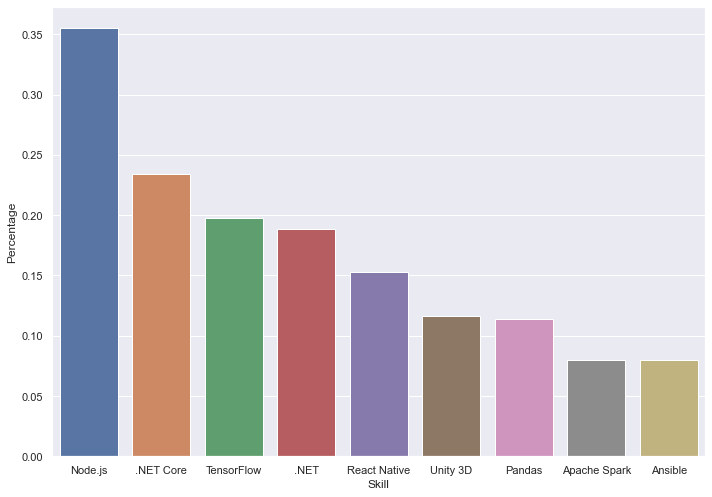

In [851]:
barplot_by_column(test_data, "MiscTechDesireNextYear", 0)

<h3> Question 4: What languages do people work with now? </h3>

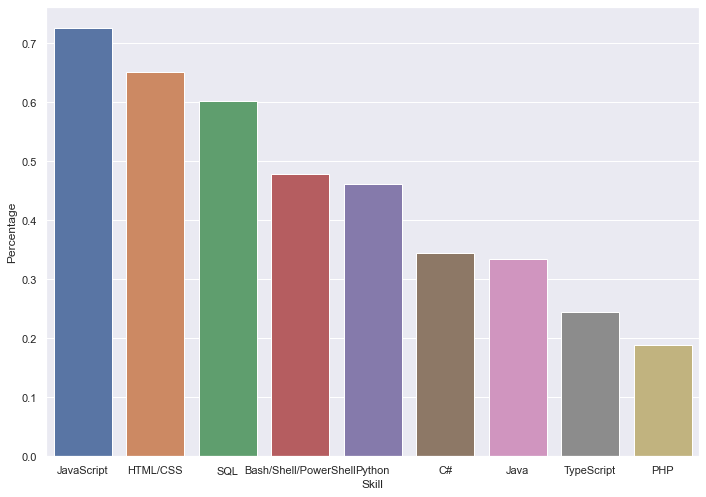

In [852]:
barplot_by_column(test_data, "LanguageWorkedWith", 0)

<h3> Question 5: What web frameworks do they use most often? </h3>

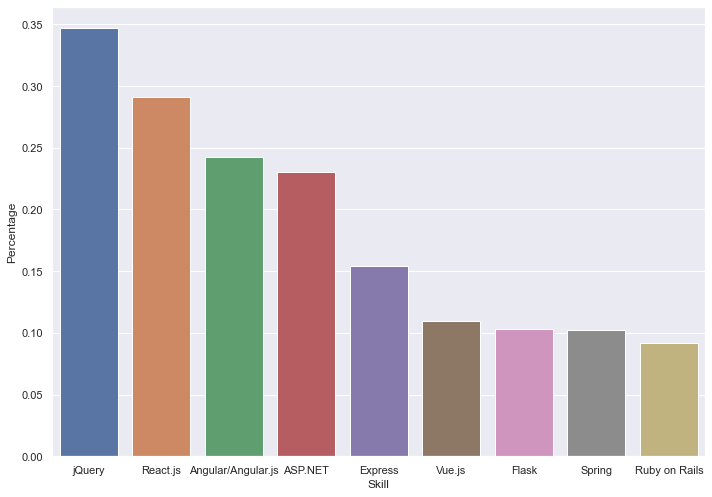

In [853]:
barplot_by_column(test_data, "WebFrameWorkedWith", 0)

<h3> Question 6: What databases do they use most often? </h3>

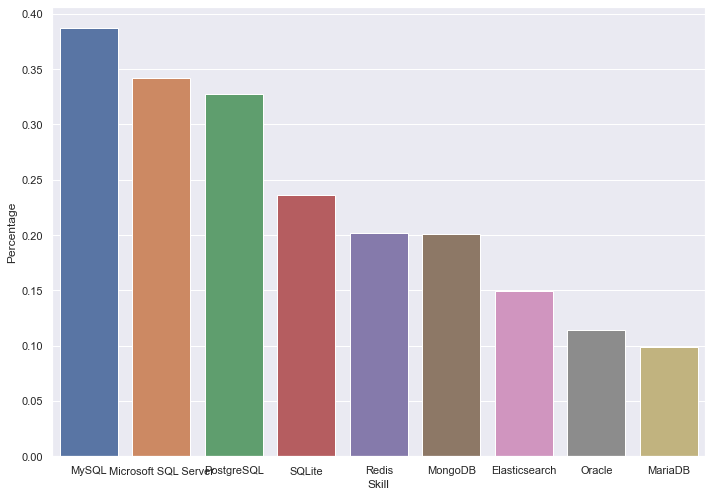

In [856]:
barplot_by_column(test_data, "DatabaseWorkedWith", 0)